# **Chapter 13 (PyTorch Recipes)**
## *Deep Learning for Time Series Forecasting*, 

This chapter covers more advanced deep learning architectures using TensorFlow/Keras and PyTorch. The chapter starts with a high-level API (Keras) and then dives into more complex implementations, using a lower-level API (PyTorch).

In this chapter, you will see the following recipes:
* Forecasting with an RNN using PyTorch
* Forecasting with LSTM using PyTorch
* Forecasting with a GRU using PyTorch

# Technical Requirements

It is recommended that you create two separate virtual Python environments – one for TensorFlow/Keras and one for PyTorch. You can install all the required dependencies and their specific versions without causing conflicts in other environments. If you prefer, you can still try and install them together in a new virtual environment. If you need a quick refresher on creating a virtual Python environment, check out the *Development environment setup* recipe from **Chapter 1**, *Getting Started with Time Series Analysis*. The chapter covers two methods – using `conda` and `venv`.

The following instructions will create two virtual environments using `conda`. You can call the environments any name you like.


### Installing PyTorch
The following example will name the environment pytorch. This will install CPU-only support:

```
conda create -n pytorch python=3.9 -y
conda activate pytorch
conda install pytorch torchvision torchaudio cpuonly -c pytorch
```

For GPU instructions, the latest information, or troubleshooting, please visit the documentation here: https://pytorch.org/.

To make the new pytorch environment visible within Jupyter, you can run the following code:

```
python -m ipykernel install --user --name pytorch --displayname "pytorch"
```

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib 
# import pytorch_lightning as pl
import torch 

# print(f'''
# Matplotlib -> {matplotlib.__version__}
# pandas -> {pd.__version__}   
# numpy -> {np.__version__}
# PyTorch Lightning -> {pl.__version__}
# Torch -> {torch.__version__}
# ''')

In [5]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [8]:
path = Path('../../datasets/Ch13/')
daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [10]:
daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

In [12]:
print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


## Tranform the data sets
### Windowing

In [15]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [17]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()

In [19]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [21]:
air_df = one_step_forecast(air_cp, 10)
en_df = one_step_forecast(en_cp, 10)
dw_df = one_step_forecast(dw_cp, 10)
print(air_df.shape)
print(en_df.shape)
print(dw_df.shape)

(134, 11)
(578, 11)
(2913, 11)


### Scale and split data

In [24]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [26]:
scale_air = Standardize(air_df)
scale_dw = Standardize(dw_df)
scale_en = Standardize(en_df)

train_air, test_air, val_air = scale_air.fit_transform()
train_dw, test_dw, val_dw = scale_dw.fit_transform()
train_en, test_en, val_en = scale_en.fit_transform()

In [28]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 109 , test: 13, val:12
weather: train: 2360 , test: 291, val:262
energy: train: 469 , test: 57, val: 52



### Split into X and Y (Features and Target)

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [69]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

In [35]:
numpy_array = train_air.values
type(numpy_array)

numpy.ndarray

In [37]:
torch_tensor = torch.from_numpy(numpy_array)
type(torch_tensor)

torch.Tensor

In [39]:
from_torch_to_numpy = torch_tensor.detach().numpy()
type(from_torch_to_numpy)

numpy.ndarray

In [41]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target_pt(train_air, 
                               val_air, 
                               test_air)

(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target_pt(train_dw, 
                             val_dw, 
                             test_dw)

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_pt(train_en, 
                             val_en, 
                             test_en)

In [43]:
# returns a Tensor object
type(x_test_air)

torch.Tensor

In [45]:
y_train_air.shape

torch.Size([109, 1])

In [47]:
x_train_air.shape

torch.Size([109, 10, 1])

# RNN/LSTM in PyTorch

## RNN Model
* The math from the PyTorch RNN class documentation

$$
\large
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [52]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [54]:
issubclass(RNN, nn.Module)

True

In [56]:
issubclass(RNN, nn.RNN)

False

In [58]:
def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history

### Air Passenger

In [61]:
params_air = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 25,
'lr': 0.01,
'train_data': (x_train_air, y_train_air),
'val_data': (x_val_air, y_val_air),
'test_data': (x_test_air, y_test_air),
'idx': test_air.index,
'scale': scale_air}

0/500 - Loss:  1.235884666442871, val_loss: 2.643882989883423
25/500 - Loss:  0.08927202969789505, val_loss: 0.3953157365322113
50/500 - Loss:  0.04020595923066139, val_loss: 0.2787416875362396
75/500 - Loss:  0.023822123184800148, val_loss: 0.24219922721385956
100/500 - Loss:  0.024430781602859497, val_loss: 0.2540401518344879
125/500 - Loss:  0.020225485786795616, val_loss: 0.2497752159833908
150/500 - Loss:  0.02166938968002796, val_loss: 0.24007146060466766
175/500 - Loss:  0.016956303268671036, val_loss: 0.19737021625041962
200/500 - Loss:  0.024188924580812454, val_loss: 0.20853368937969208
225/500 - Loss:  0.01701529510319233, val_loss: 0.19413797557353973
250/500 - Loss:  0.020770227536559105, val_loss: 0.1776621788740158
275/500 - Loss:  0.017958946526050568, val_loss: 0.21245114505290985
300/500 - Loss:  0.015437460504472256, val_loss: 0.2222646027803421
325/500 - Loss:  0.013363230042159557, val_loss: 0.20821703970432281
350/500 - Loss:  0.01657281257212162, val_loss: 0.2387

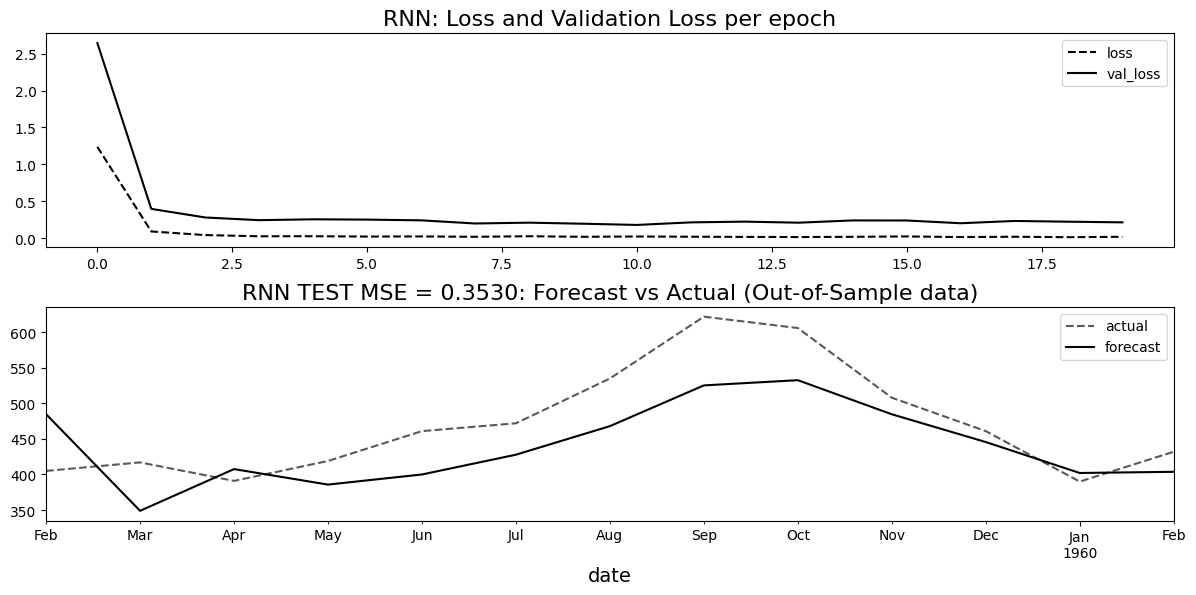

In [63]:
air_rnn, history_a_rnn = train_model_pt('RNN', **params_air)

### Avg Daily Temperature

0/500 - Loss:  0.9942436814308167, val_loss: 0.6773791909217834
20/500 - Loss:  0.40071597695350647, val_loss: 0.3693927824497223
40/500 - Loss:  0.3668382167816162, val_loss: 0.34769296646118164
60/500 - Loss:  0.34171876311302185, val_loss: 0.341265469789505
80/500 - Loss:  0.31395772099494934, val_loss: 0.3878338038921356
100/500 - Loss:  0.2777625024318695, val_loss: 0.4275437593460083
120/500 - Loss:  0.27007052302360535, val_loss: 0.4312227666378021
140/500 - Loss:  0.2560221552848816, val_loss: 0.4695736765861511
160/500 - Loss:  0.23758234083652496, val_loss: 0.46873971819877625
180/500 - Loss:  0.22540096938610077, val_loss: 0.5205879211425781
200/500 - Loss:  0.2216503918170929, val_loss: 0.4847967028617859
220/500 - Loss:  0.2176661640405655, val_loss: 0.6468387246131897
240/500 - Loss:  0.20825336873531342, val_loss: 0.6076148152351379
260/500 - Loss:  0.1907098889350891, val_loss: 0.6254894137382507
280/500 - Loss:  0.19354014098644257, val_loss: 0.6445727944374084
300/500

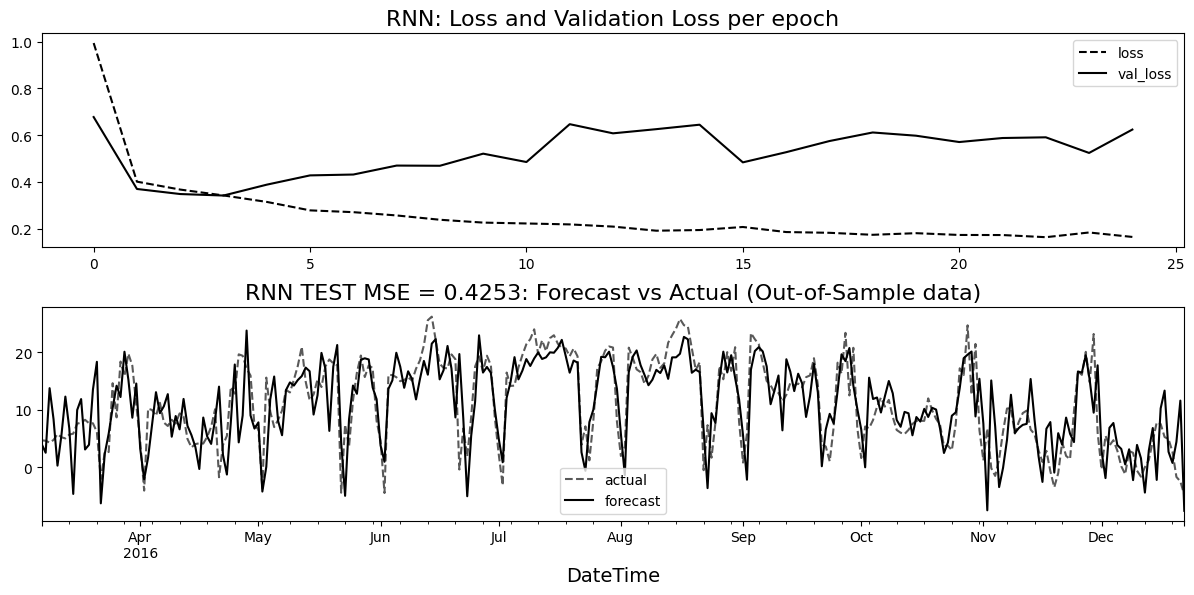

In [68]:
params_dw = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_dw, y_train_dw),
'val_data': (x_val_dw, y_val_dw),
'test_data': (x_test_dw, y_test_dw),
'idx': test_dw.index,
'scale': scale_dw}

dw_rnn, history_dw_rnn = train_model_pt('RNN', **params_dw)

### Energy Consumption

0/500 - Loss:  1.106183648109436, val_loss: 1.0391106605529785
20/500 - Loss:  0.10501609742641449, val_loss: 0.18473750352859497
40/500 - Loss:  0.0916137844324112, val_loss: 0.15399578213691711
60/500 - Loss:  0.07720910012722015, val_loss: 0.15661659836769104
80/500 - Loss:  0.06970381736755371, val_loss: 0.15340732038021088
100/500 - Loss:  0.06201183423399925, val_loss: 0.1525912880897522
120/500 - Loss:  0.05343854799866676, val_loss: 0.1546686440706253
140/500 - Loss:  0.054228540509939194, val_loss: 0.14933837950229645
160/500 - Loss:  0.052068665623664856, val_loss: 0.1461392045021057
180/500 - Loss:  0.05347912758588791, val_loss: 0.13530829548835754
200/500 - Loss:  0.05112841725349426, val_loss: 0.13326135277748108
220/500 - Loss:  0.048045564442873, val_loss: 0.13232752680778503
240/500 - Loss:  0.0461612194776535, val_loss: 0.1336992383003235
260/500 - Loss:  0.04974907636642456, val_loss: 0.1358000934123993
280/500 - Loss:  0.04391930252313614, val_loss: 0.13883592188358

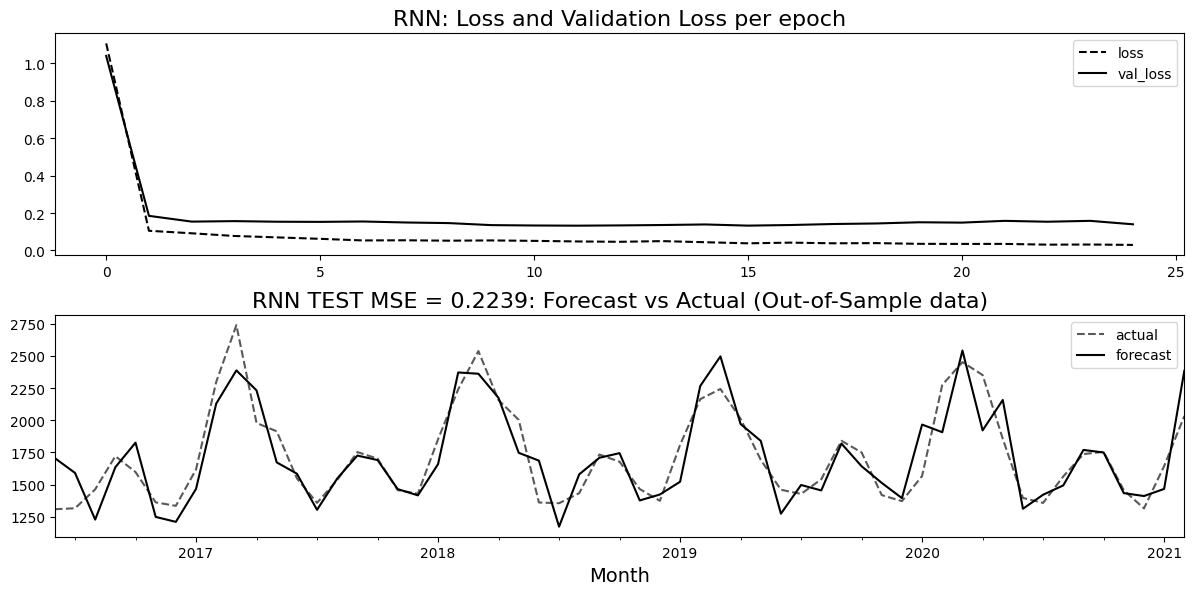

In [70]:
params_en = {'input_size':x_train_air.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_en, y_train_en),
'val_data': (x_val_en, y_val_en),
'test_data': (x_test_en, y_test_en),
'idx': test_en.index,
'scale': scale_en}

en_rnn, history_en_rnn = train_model_pt('RNN', **params_en)

## LSTM Model 
* The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$

In [73]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

### Air Passenger

0/500 - Loss:  0.9845251441001892, val_loss: 2.904437780380249
25/500 - Loss:  0.12455590814352036, val_loss: 0.6426330208778381
50/500 - Loss:  0.0651131421327591, val_loss: 0.39189982414245605
75/500 - Loss:  0.03897693008184433, val_loss: 0.382744163274765
100/500 - Loss:  0.030542774125933647, val_loss: 0.5035427212715149
125/500 - Loss:  0.02227247692644596, val_loss: 0.360660582780838
150/500 - Loss:  0.024366479367017746, val_loss: 0.4700138568878174
175/500 - Loss:  0.04253730550408363, val_loss: 0.3794851303100586
200/500 - Loss:  0.02500801347196102, val_loss: 0.4688589870929718
225/500 - Loss:  0.02708621881902218, val_loss: 0.4020631015300751
250/500 - Loss:  0.040115587413311005, val_loss: 0.536292552947998
275/500 - Loss:  0.01860804669559002, val_loss: 0.39553800225257874
300/500 - Loss:  0.019555289298295975, val_loss: 0.3892469108104706
325/500 - Loss:  0.023063721135258675, val_loss: 0.3773129880428314
350/500 - Loss:  0.020768659189343452, val_loss: 0.420274764299392

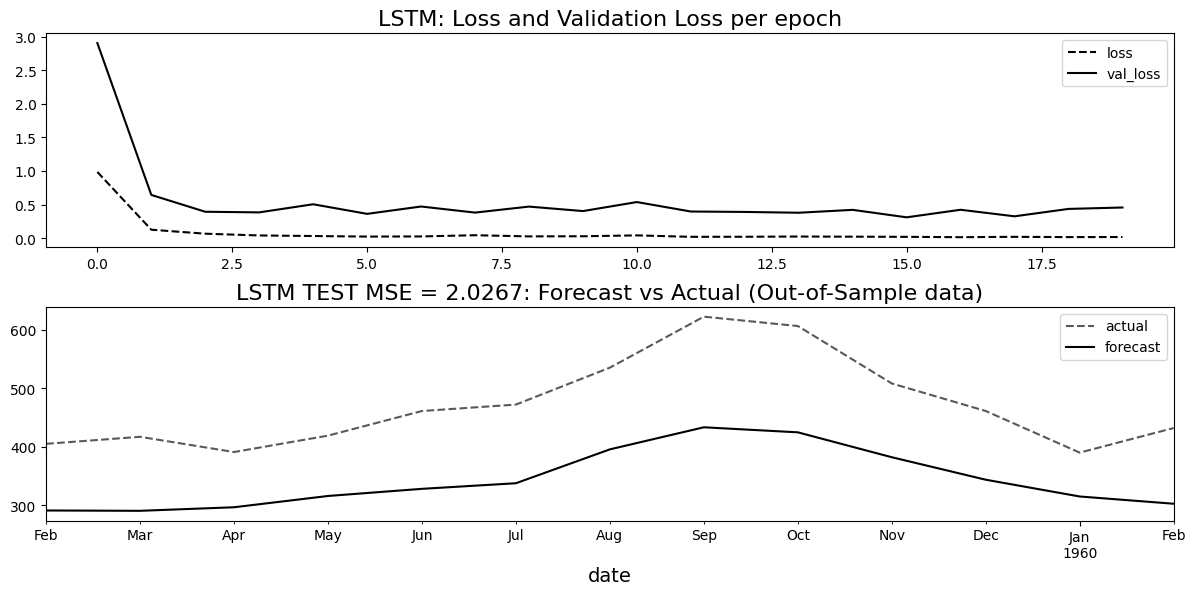

In [75]:
air_lstm, history_a_lstm = train_model_pt('LSTM', **params_air)

### Avg Daily Temperature

0/500 - Loss:  1.0079634189605713, val_loss: 0.8060876131057739
20/500 - Loss:  0.41818493604660034, val_loss: 0.37450677156448364
40/500 - Loss:  0.33969399333000183, val_loss: 0.3302748501300812
60/500 - Loss:  0.2978121042251587, val_loss: 0.3043144643306732
80/500 - Loss:  0.2715252637863159, val_loss: 0.3046383857727051
100/500 - Loss:  0.2397940456867218, val_loss: 0.32535412907600403
120/500 - Loss:  0.21392440795898438, val_loss: 0.319261372089386
140/500 - Loss:  0.1933303028345108, val_loss: 0.29630565643310547
160/500 - Loss:  0.1755453646183014, val_loss: 0.24865908920764923
180/500 - Loss:  0.1655036062002182, val_loss: 0.26616397500038147
200/500 - Loss:  0.1666833609342575, val_loss: 0.26755863428115845
220/500 - Loss:  0.1505693644285202, val_loss: 0.2984372675418854
240/500 - Loss:  0.13803668320178986, val_loss: 0.3064948618412018
260/500 - Loss:  0.13396219909191132, val_loss: 0.3010798692703247
280/500 - Loss:  0.12734800577163696, val_loss: 0.30827754735946655
300/

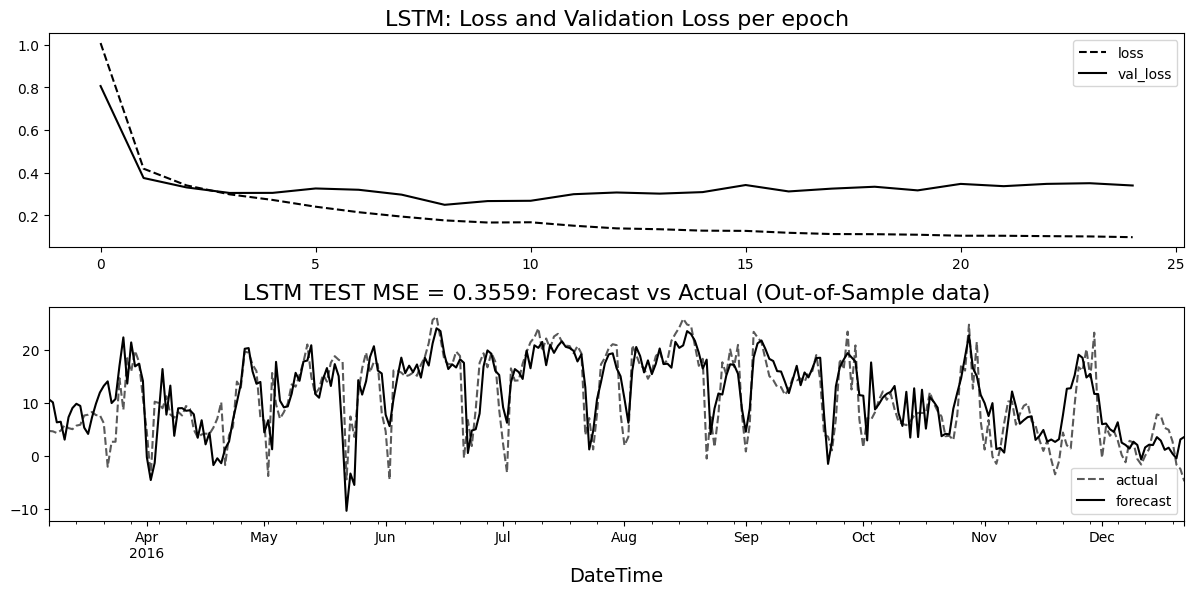

In [77]:
dw_lstm, history_dw_lstm = train_model_pt('LSTM', **params_dw)

### Energy Consumption

0/500 - Loss:  1.0597141981124878, val_loss: 1.3468912839889526
20/500 - Loss:  0.13891330361366272, val_loss: 0.24158883094787598
40/500 - Loss:  0.07815784960985184, val_loss: 0.17676714062690735
60/500 - Loss:  0.06602878123521805, val_loss: 0.15786555409431458
80/500 - Loss:  0.0631597563624382, val_loss: 0.14532430469989777
100/500 - Loss:  0.060315608978271484, val_loss: 0.1384289264678955
120/500 - Loss:  0.05031602829694748, val_loss: 0.13283592462539673
140/500 - Loss:  0.05046343430876732, val_loss: 0.12544630467891693
160/500 - Loss:  0.043180640786886215, val_loss: 0.1250763237476349
180/500 - Loss:  0.04821454733610153, val_loss: 0.12707804143428802
200/500 - Loss:  0.04121311381459236, val_loss: 0.1234818771481514
220/500 - Loss:  0.038431838154792786, val_loss: 0.12139187753200531
240/500 - Loss:  0.036620255559682846, val_loss: 0.11965262144804001
260/500 - Loss:  0.03506524860858917, val_loss: 0.12126373499631882
280/500 - Loss:  0.03897913917899132, val_loss: 0.124790

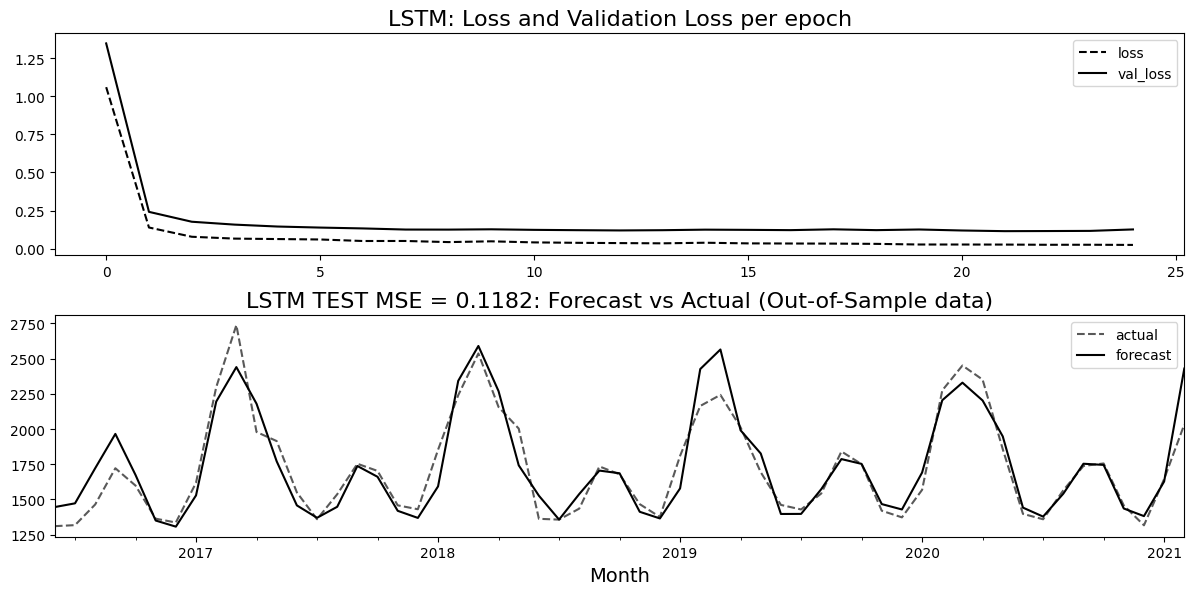

In [79]:
en_lstm, history_en_lstm = train_model_pt('LSTM', **params_en)

## LSTM with Dropout

In [81]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True, dropout=0.70)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

0/500 - Loss:  1.0207854509353638, val_loss: 1.1334493160247803
20/500 - Loss:  0.12094704061746597, val_loss: 0.25224465131759644
40/500 - Loss:  0.0749843418598175, val_loss: 0.19560153782367706
60/500 - Loss:  0.06916029006242752, val_loss: 0.17461225390434265
80/500 - Loss:  0.06259751319885254, val_loss: 0.16025759279727936
100/500 - Loss:  0.05607829615473747, val_loss: 0.14967265725135803
120/500 - Loss:  0.054155826568603516, val_loss: 0.14236980676651
140/500 - Loss:  0.04988197237253189, val_loss: 0.14160296320915222
160/500 - Loss:  0.04820694774389267, val_loss: 0.12899957597255707
180/500 - Loss:  0.0423688106238842, val_loss: 0.12960581481456757
200/500 - Loss:  0.046745575964450836, val_loss: 0.13173288106918335
220/500 - Loss:  0.04583011940121651, val_loss: 0.1246989294886589
240/500 - Loss:  0.03773471340537071, val_loss: 0.12598812580108643
260/500 - Loss:  0.03706696629524231, val_loss: 0.12568899989128113
280/500 - Loss:  0.037294939160346985, val_loss: 0.121136777

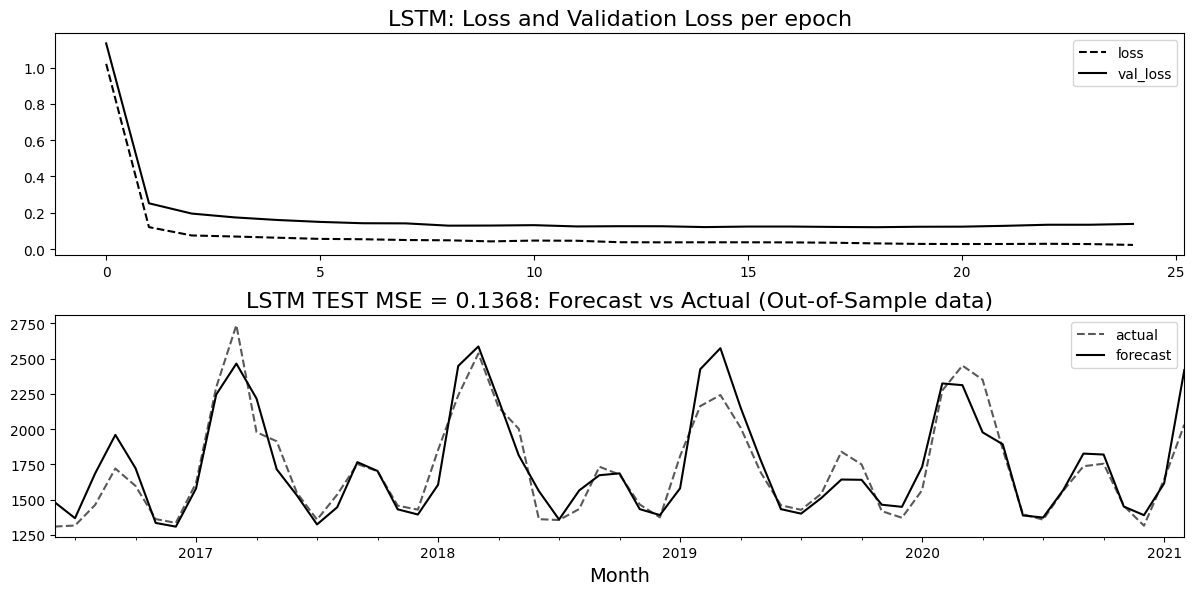

In [82]:
en_lstm_d, history_en_lstm_d = train_model_pt('LSTM', **params_en)

## GRU
* The math from the PyTorch GRU documentation

$$
\large
\begin{array}{ll}
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
    \end{array}
$$

In [91]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.gÇru(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

### Air Passenger

0/500 - Loss:  1.0347174406051636, val_loss: 3.055645227432251
25/500 - Loss:  0.10556567460298538, val_loss: 0.4974677264690399
50/500 - Loss:  0.04850362241268158, val_loss: 0.37583890557289124
75/500 - Loss:  0.03259005770087242, val_loss: 0.3084844946861267
100/500 - Loss:  0.03554094210267067, val_loss: 0.3716065585613251
125/500 - Loss:  0.024552838876843452, val_loss: 0.3440718352794647
150/500 - Loss:  0.01922627165913582, val_loss: 0.3426222801208496
175/500 - Loss:  0.029549425467848778, val_loss: 0.38720953464508057
200/500 - Loss:  0.02064717374742031, val_loss: 0.3715466558933258
225/500 - Loss:  0.03148200362920761, val_loss: 0.376954048871994
250/500 - Loss:  0.02159241773188114, val_loss: 0.4130629599094391
275/500 - Loss:  0.019175143912434578, val_loss: 0.29313862323760986
300/500 - Loss:  0.017946096137166023, val_loss: 0.31765368580818176
325/500 - Loss:  0.016615502536296844, val_loss: 0.314954549074173
350/500 - Loss:  0.014828312210738659, val_loss: 0.31696531176

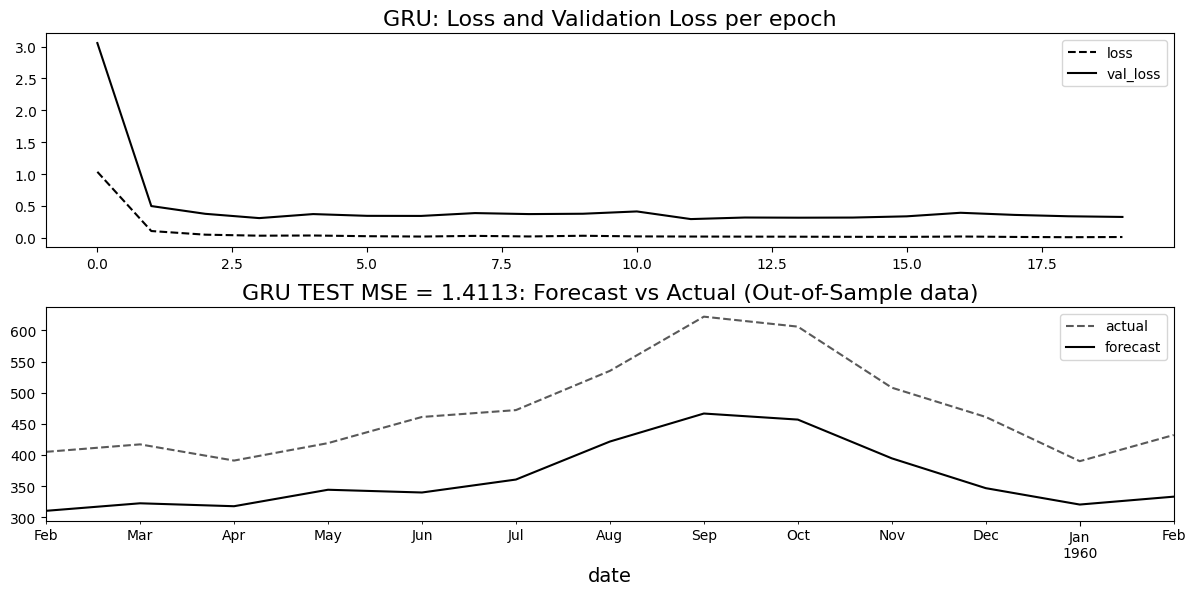

In [94]:
air_gru, history_a_gru = train_model_pt('GRU', **params_air)

### Avg Daily Temperature

0/500 - Loss:  0.9718328714370728, val_loss: 0.8028543591499329
20/500 - Loss:  0.4186305105686188, val_loss: 0.3653848171234131
40/500 - Loss:  0.33275943994522095, val_loss: 0.3216482400894165
60/500 - Loss:  0.3002568483352661, val_loss: 0.30267441272735596
80/500 - Loss:  0.2620663046836853, val_loss: 0.2912021577358246
100/500 - Loss:  0.22906142473220825, val_loss: 0.25780168175697327
120/500 - Loss:  0.22094178199768066, val_loss: 0.26268529891967773
140/500 - Loss:  0.2009691596031189, val_loss: 0.29376885294914246
160/500 - Loss:  0.1843019723892212, val_loss: 0.2845730781555176
180/500 - Loss:  0.17003846168518066, val_loss: 0.28710442781448364
200/500 - Loss:  0.1611284613609314, val_loss: 0.29178962111473083
220/500 - Loss:  0.15567421913146973, val_loss: 0.28822091221809387
240/500 - Loss:  0.14270596206188202, val_loss: 0.30985406041145325
260/500 - Loss:  0.13585326075553894, val_loss: 0.3135145604610443
280/500 - Loss:  0.12493941932916641, val_loss: 0.3310600817203522


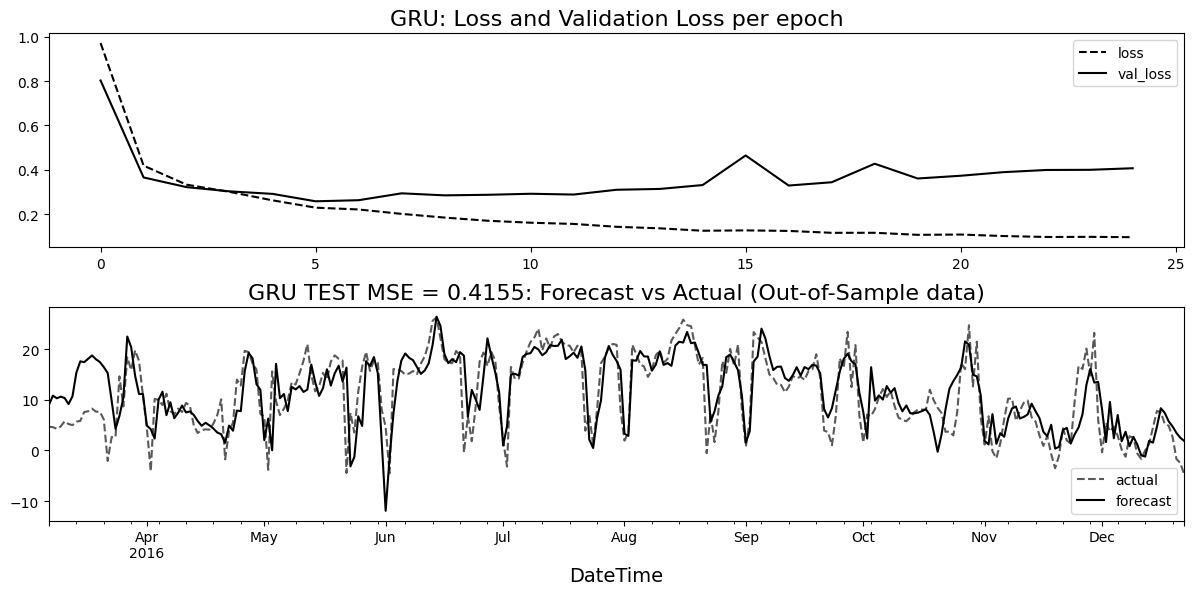

In [97]:
dw_gru, history_dw_gru = train_model_pt('GRU', **params_dw)

### Energy Consumption

0/500 - Loss:  1.0597684383392334, val_loss: 1.2160098552703857
20/500 - Loss:  0.13124851882457733, val_loss: 0.23358486592769623
40/500 - Loss:  0.08636611700057983, val_loss: 0.16942831873893738
60/500 - Loss:  0.06731874495744705, val_loss: 0.15536043047904968
80/500 - Loss:  0.06622552126646042, val_loss: 0.14540459215641022
100/500 - Loss:  0.050007063895463943, val_loss: 0.14040806889533997
120/500 - Loss:  0.0527336411178112, val_loss: 0.13976356387138367
140/500 - Loss:  0.04274754971265793, val_loss: 0.13700707256793976
160/500 - Loss:  0.04588128998875618, val_loss: 0.13845416903495789
180/500 - Loss:  0.04268356040120125, val_loss: 0.13897933065891266
200/500 - Loss:  0.03862289711833, val_loss: 0.13064205646514893
220/500 - Loss:  0.037707265466451645, val_loss: 0.1265929490327835
240/500 - Loss:  0.03652410954236984, val_loss: 0.12462881207466125
260/500 - Loss:  0.035882480442523956, val_loss: 0.12225181609392166
280/500 - Loss:  0.029211802408099174, val_loss: 0.1204105

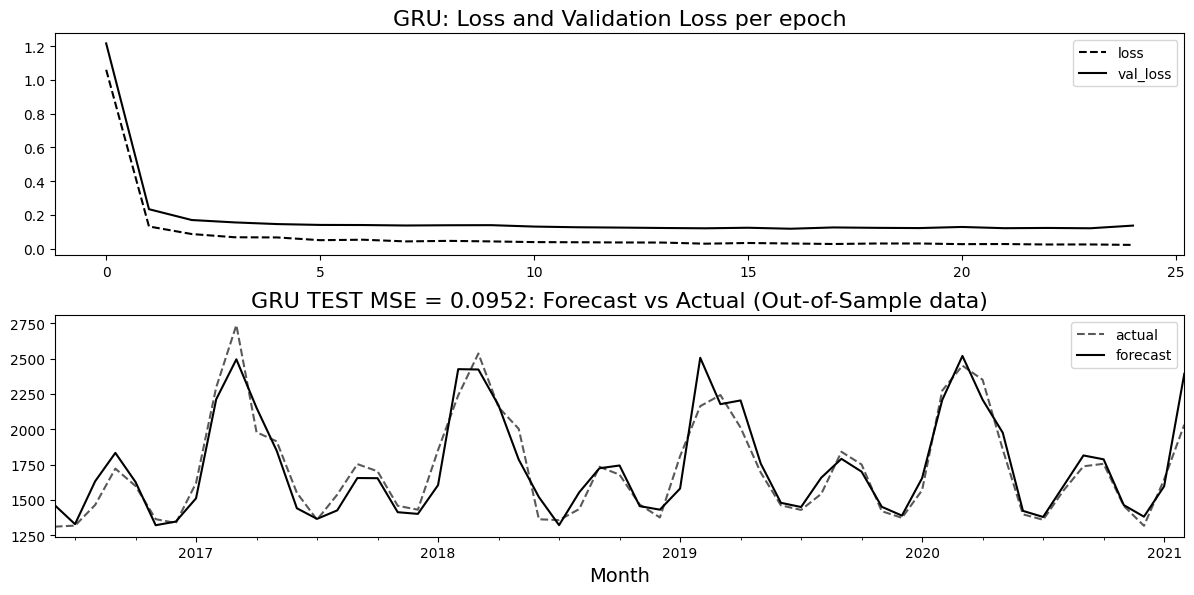

In [99]:
en_gru, history_en_gru = train_model_pt('GRU', **params_en)

## There is more

In [101]:
n_hidden = 32
input_size = x_train_en.shape[1]
n_layers = 1
output = 1

In [102]:
model_lstm_seq = torch.nn.Sequential(
    torch.nn.LSTM(input_size, n_hidden, n_layers),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_hidden, output)
)

In [103]:
model_gru_seq = torch.nn.Sequential(
    torch.nn.GRU(input_size, n_hidden, n_layers),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(n_hidden, output)
)

In [104]:
model_lstm_seq

Sequential(
  (0): LSTM(10, 32)
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=32, out_features=1, bias=True)
)